# Visualizing Adversarial Perturbations

This notebook introduces some examples to visualize perturbations and model activations.  See [Adversarial Robustness as a Prior for Learned Representations](https://arxiv.org/abs/1906.00945) for additional visualizations one could do.

This notebook requires access to the [ImageNet](https://www.image-net.org/) dataset.

The dataset, `RestrictedImageNet`, and the visualiations are defined in [Adversarial Robustness as a Prior for Learned Representations](https://arxiv.org/abs/1906.00945) and is provided in `rai_toolbox.dataset.RestrictedImageNet`.


## Imports

In [1]:
%matplotlib inline
import random
from pathlib import Path

import configs
import matplotlib.pyplot as plt
import torch
from hydra_zen import builds, instantiate, make_config

random.seed(5643)

## Instantiate

In [2]:
# instantiate the dataset
# Note: the dataset this is loading up only contains
# one image per class so you may not extract the same
# image below
data_dir = f"{Path.home()}/.torch/data/imagenet/normal/val/"
ds = instantiate(configs.RestrictedImageNet(root=data_dir))

In [3]:
# Dictionary of class name to index of label
class_to_id = dict(
    Dog=0, Cat=1, Frog=2, Turtle=3, Bird=4, Monkey=5, Fish=6, Crab=7, Insect=8
)

# Dictionary of index of label to class name
id_to_class = {v: k for k, v in class_to_id.items()}

In [4]:
# instantiate the model and load the checkpoint
ckpt = "mitll_restricted_imagenet_l2_3_0.pt"
model = instantiate(configs.RestictedImageNetModel, ckpt=ckpt)

# instantiate the L2PGD perturbation method
l2pgd = instantiate(configs.L2PGD)

## Load and Evaluate Image

Text(0.5, 1.0, 'True: Frog Pred: Dog')

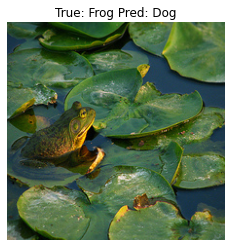

In [5]:
img, target = ds[0]
with torch.no_grad():
    logit = model(img[None])

plt.axis("off")
plt.imshow(img.numpy().transpose(1, 2, 0))
plt.title(f"True: {id_to_class[target]} Pred: {id_to_class[logit.argmax().item()]}")

## Generate Large Perturbation using PGD

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'True: Frog Pred: Dog')

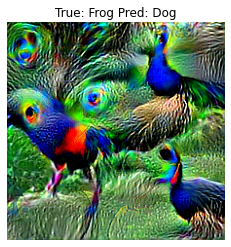

In [6]:
l2pgd = instantiate(configs.L2PGD, epsilon=100, steps=10)
l2pgd
img_adv, _ = l2pgd(model=model, data=img[None], target=torch.tensor([target]),)

with torch.no_grad():
    logit_adv = model(img_adv)

plt.axis("off")
plt.imshow(img_adv[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.title(f"True: {id_to_class[target]} Pred: {id_to_class[logit_adv.argmax().item()]}")

## Visualize an Activation From the Latent Layer

In [7]:
from rai_experiments.models.resnet import resnet50
from torch import nn

# To propagate gradients through the "zero-region" of a ReLU activation
VizModel = builds(
    nn.Sequential,
    configs.ImageNetNormalizer,
    configs.LoadFromCheckpoint(
        model=builds(resnet50, viz_relu=True, with_latent=True, num_classes=9),
        ckpt=ckpt,
    ),
)
viz_model = instantiate(VizModel)
viz_model.eval()

# Custom loss to maximize a given component of the representation vector
def feature_vis_loss(rep, targ):
    return rep[:, targ]

Visualization of Activation: 883


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'True: Frog Pred: Dog')

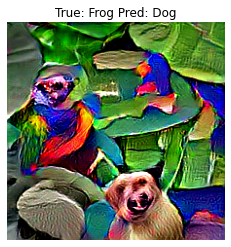

In [8]:
l2pgd_viz = instantiate(configs.L2PGD, use_best=False, epsilon=100, steps=20)

ACTIVATION = random.randint(0, 2047)
print(f"Visualization of Activation: {ACTIVATION}")

img_adv, _ = l2pgd_viz(
    model=viz_model,
    data=img[None],
    target=torch.tensor([ACTIVATION]),
    criterion=feature_vis_loss,
)

with torch.no_grad():
    logit_adv = model(img_adv)

plt.axis("off")
plt.imshow(img_adv[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.title(f"True: {id_to_class[target]} Pred: {id_to_class[logit.argmax().item()]}")